In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.special import expit as plogis


from utils.helpers import *
from utils.t_learners import *

## DGP

In [2]:
def dgp_simulation(n_obs=20000, 
                   SEED=123,
                   beta_0=0.45,        # Intercept
                   beta_t=-0.85,       # Treatement Effect
                   beta_X=[-0.5, 0.1], # Effects of Covariates
                   beta_TX=[0.7],      # Interaction Effect
                   p0=0,               # Noise variables 
                   confounder=False
                   ):
    
    np.random.seed(SEED)

    p = len(beta_X) 
    mu = np.zeros(p + p0)
    rho = 0.1
    Sigma = np.full((p + p0, p + p0), rho)
    np.fill_diagonal(Sigma, 1)                                                   # Covariance Matrix

    data = multivariate_normal.rvs(mean=mu, cov=Sigma, size=n_obs)
    data_df = pd.DataFrame(data, columns=[f'X{i+1}' for i in range(p + p0)])

    beta_X_full = np.array(beta_X + [0] * p0)                                    # array with covarites  + noise vars
    beta_TX = np.array(beta_TX)

    if confounder is not False:
        Tr = np.random.binomial(1, plogis(0.5 * data_df.iloc[:, confounder]), size=n_obs)
    else:
        Tr = np.random.binomial(1, 0.5, size=n_obs)                             # Random Treatment RCT

    Tr = np.array(Tr)
    X_effect = data @ beta_X_full   #XtB
    interaction = (data[:, :len(beta_TX)] @ beta_TX) * Tr                     # treated pats get an additionl effect beta _TX

    logit_Y = beta_0 + beta_t * Tr + X_effect + interaction                    # dgp for generating Y

    Y_prob = plogis(logit_Y)
    Y = np.random.binomial(1, Y_prob)                                          # sampling Y 

    Y1 = plogis(beta_0 + beta_t + X_effect + data[:, 0] * beta_TX[0])
    Y0 = plogis(beta_0 + X_effect)
    ITE_true = Y1 - Y0

    simulated_df = pd.DataFrame({
        'ID': np.arange(1, n_obs + 1),
        'Y': Y,
        'Treatment': Tr,
        **data_df,
        'Y1': Y1,
        'Y0': Y0,
        'ITE_true': ITE_true,
        'Y_prob': Y_prob
    })

    return simulated_df


## 1. Data

In [3]:
df = dgp_simulation(n_obs=10000)
df_train, df_val, df_calib, df_test = split_train_val_calib_test(df)
df_train.head(5)

,ID,Y,Treatment,X1,X2,Y1,Y0,ITE_true,Y_prob
0,958,0,1,0.758373,-2.238725,0.384096,0.461810,-0.077714,0.384096
1,6995,1,1,0.559989,1.628267,0.468747,0.582448,-0.113701,0.468747
2,5389,1,1,-0.307757,1.881485,0.432072,0.688266,-0.256195,0.432072
3,7858,0,1,-1.449121,-0.674184,0.319245,0.751596,-0.432351,0.319245
4,7361,0,0,0.189128,1.414498,0.445042,0.621727,-0.176685,0.621727


In [4]:
df_train.describe()


,ID,Y,Treatment,X1,X2,Y1,Y0,ITE_true,Y_prob
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,4938.410250,0.498750,0.494750,-0.006676,0.003082,0.402346,0.605387,-0.203041,0.503590
std,2932.005437,0.500061,0.500035,1.016375,0.964719,0.055702,0.114723,0.163418,0.134833
min,2.000000,0.000000,0.000000,-3.589737,-3.389954,0.222436,0.214617,-0.662865,0.222436
25%,2364.750000,0.000000,0.000000,-0.690294,-0.640723,0.363827,0.526610,-0.318822,0.395509
50%,4860.500000,0.000000,0.000000,-0.002719,-0.005045,0.400865,0.611418,-0.209128,0.468864
75%,7551.500000,1.000000,1.000000,0.683277,0.657552,0.439212,0.691135,-0.092397,0.610523
max,9999.000000,1.000000,1.000000,3.566141,3.673372,0.619203,0.908508,0.380560,0.894793


In [5]:
ate_train = df_train['ITE_true'].mean();print(f"True ATE (train):   {ate_train:.4f}")
ate_val = df_val['ITE_true'].mean();print(f"True ATE (val):     {ate_val:.4f}")
ate_calib = df_calib['ITE_true'].mean();print(f"True ATE (calib):   {ate_calib:.4f}")
ate_test = df_test['ITE_true'].mean();print(f"True ATE (test):    {ate_test:.4f}")

True ATE (train):   -0.2030
True ATE (val):     -0.1987
True ATE (calib):   -0.2050
True ATE (test):    -0.2118


## logistisc Regression

Test Mean absolute error: 0.01364330286087964
Train Mean absolute error: 0.01346407655089846


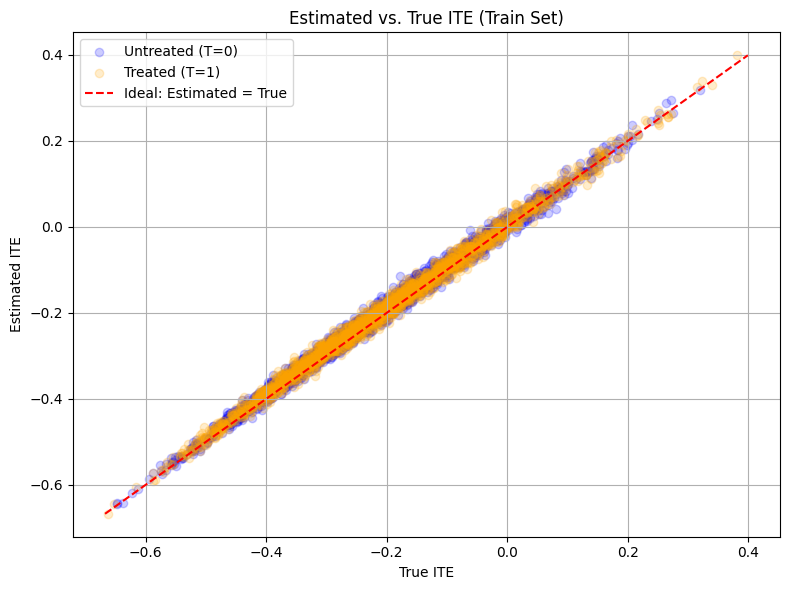

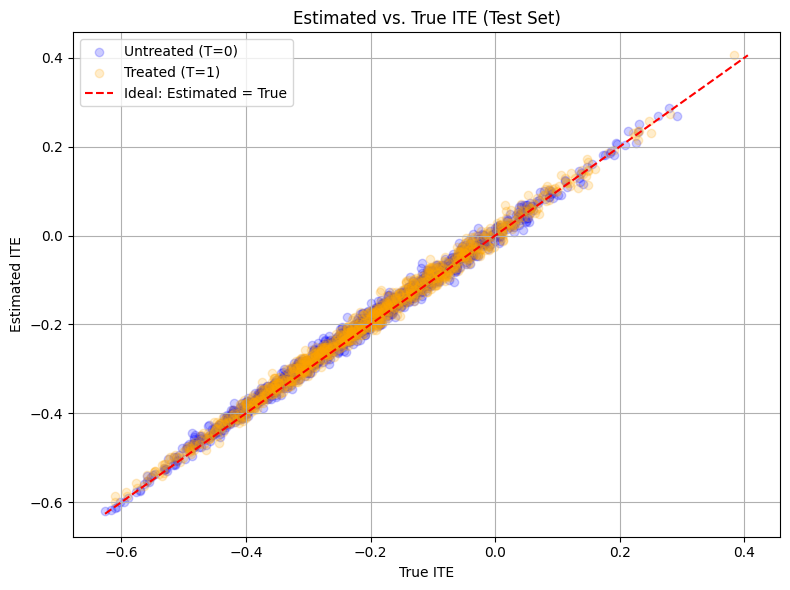

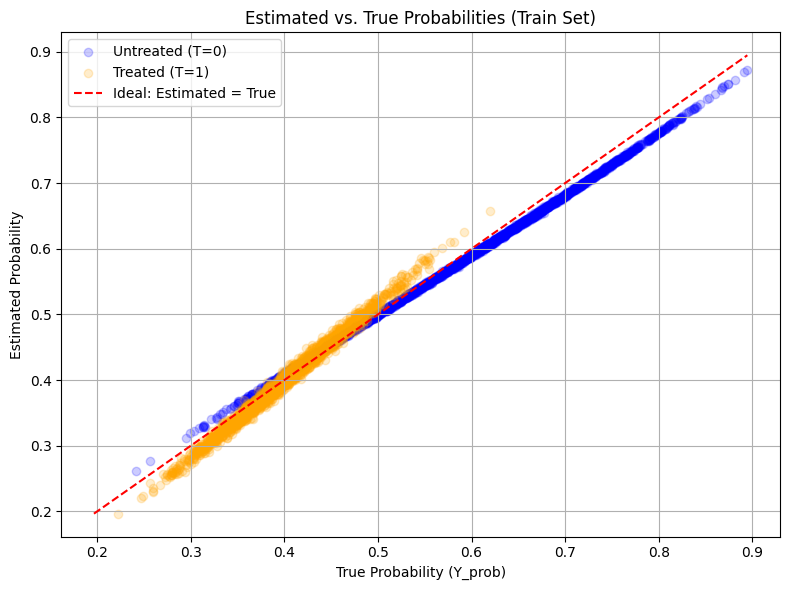

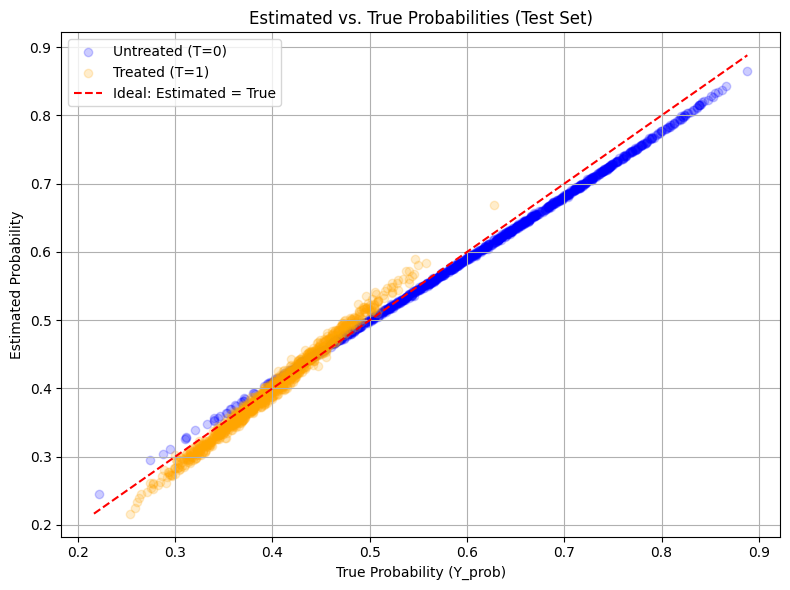

Estimated ATE (train): -0.1933
Estimated ATE (test):  -0.2021


In [6]:
# t learner logsitc
df_result_train, df_result_test, model_t, model_u = t_learner_logistic(df_train, df_test, feature_cols=['X1', 'X2'])

# MAE train Vs test
if 'ITE_true' in df_result_test.columns:
    print("Test Mean absolute error:", np.mean(np.abs(df_result_test['ITE_hat'] - df_result_test['ITE_true'])))

if 'ITE_true' in df_result_train.columns:
    print("Train Mean absolute error:", np.mean(np.abs(df_result_train['ITE_hat'] - df_result_train['ITE_true'])))


plot_estimated_vs_true_ite_colored(df_result_train, title_suffix='(Train Set)')
plot_estimated_vs_true_ite_colored(df_result_test, title_suffix='(Test Set)')

plot_estimated_vs_true_probabilities(df_result_train, title_suffix='(Train Set)')
plot_estimated_vs_true_probabilities(df_result_test, title_suffix='(Test Set)')

estimated_ate_train = df_result_train['ITE_hat'].mean()
estimated_ate_test = df_result_test['ITE_hat'].mean()
print(f"Estimated ATE (train): {estimated_ate_train:.4f}")
print(f"Estimated ATE (test):  {estimated_ate_test:.4f}")

## RF Default

Test MAE: 0.2232682248085629
Train MAE: 0.315827340170755


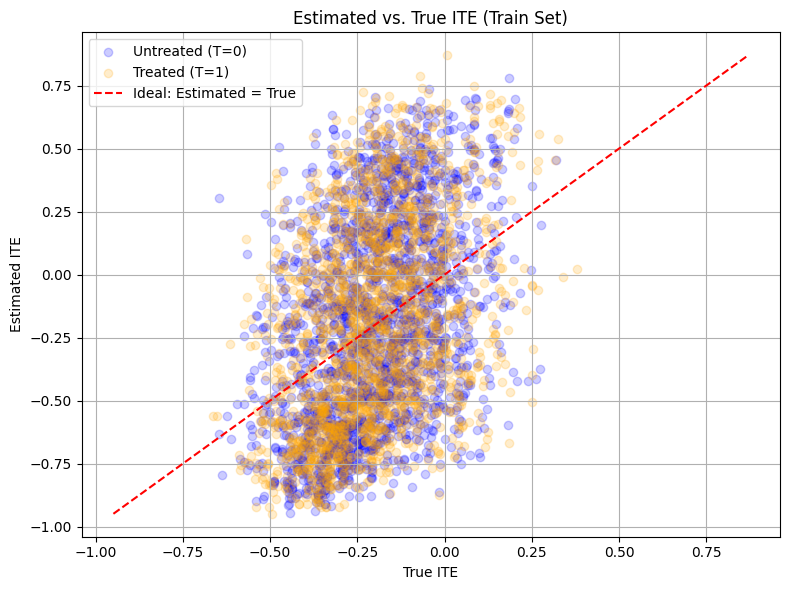

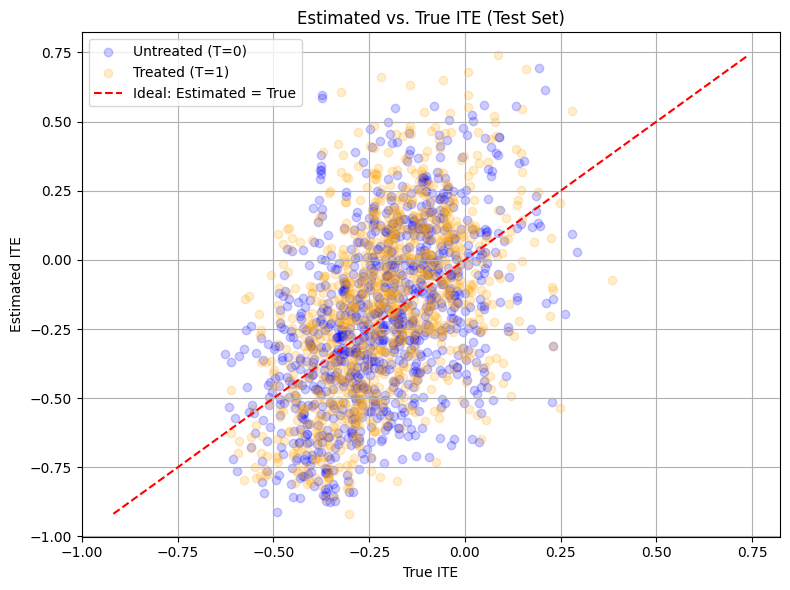

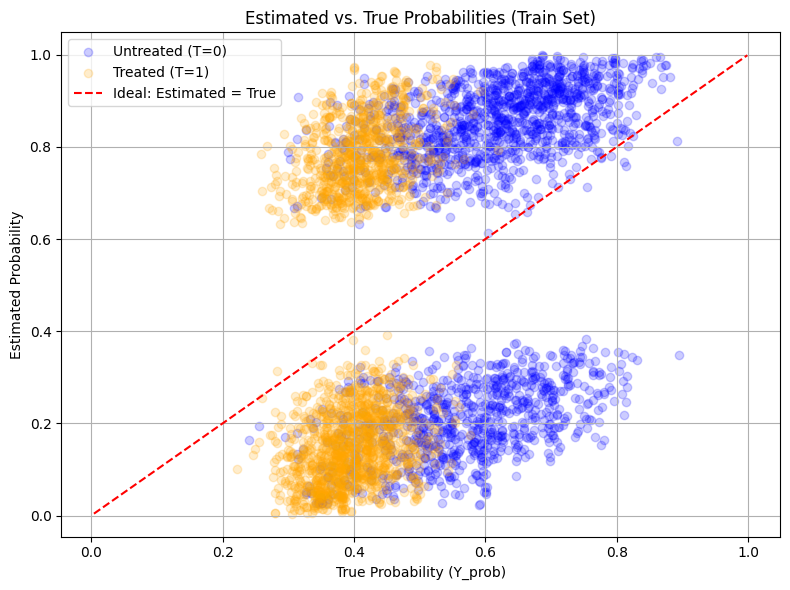

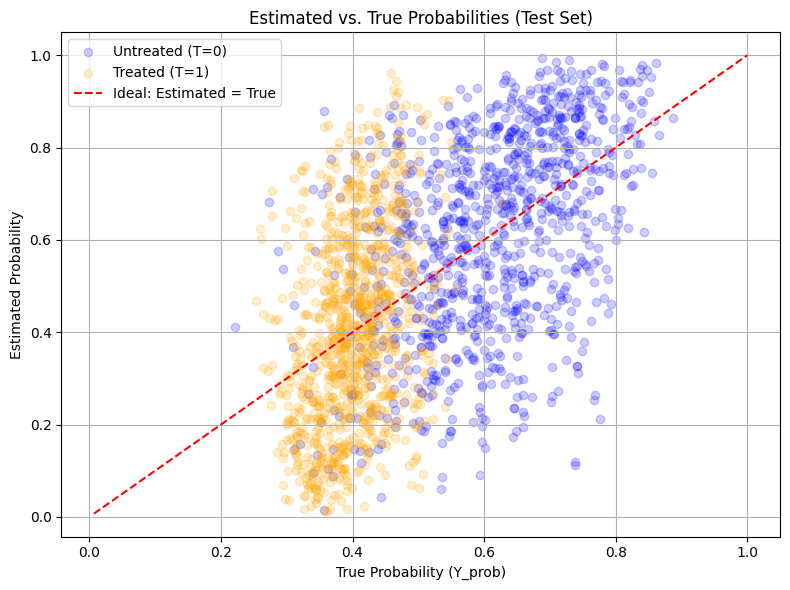

Estimated ATE (train): -0.1952
Estimated ATE (test):  -0.1955


In [7]:
feature_cols = ['X1', 'X2']
df_result_train, df_result_test, model_t, model_u = t_learner_random_forest(df_train, df_test, feature_cols)

if 'ITE_true' in df_result_test.columns:
    print("Test MAE:", np.mean(np.abs(df_result_test['ITE_hat'] - df_result_test['ITE_true'])))
if 'ITE_true' in df_result_train.columns:
    print("Train MAE:", np.mean(np.abs(df_result_train['ITE_hat'] - df_result_train['ITE_true'])))

plot_estimated_vs_true_ite_colored(df_result_train, title_suffix="(Train Set)")
plot_estimated_vs_true_ite_colored(df_result_test, title_suffix="(Test Set)")

plot_estimated_vs_true_probabilities(df_result_train, title_suffix='(Train Set)')
plot_estimated_vs_true_probabilities(df_result_test, title_suffix='(Test Set)')

estimated_ate_train = df_result_train['ITE_hat'].mean()
estimated_ate_test = df_result_test['ITE_hat'].mean()
print(f"Estimated ATE (train): {estimated_ate_train:.4f}")
print(f"Estimated ATE (test):  {estimated_ate_test:.4f}")

## RF tuned with params from CV 

Test MAE: 0.06073988182480182
Train MAE: 0.062792158962856


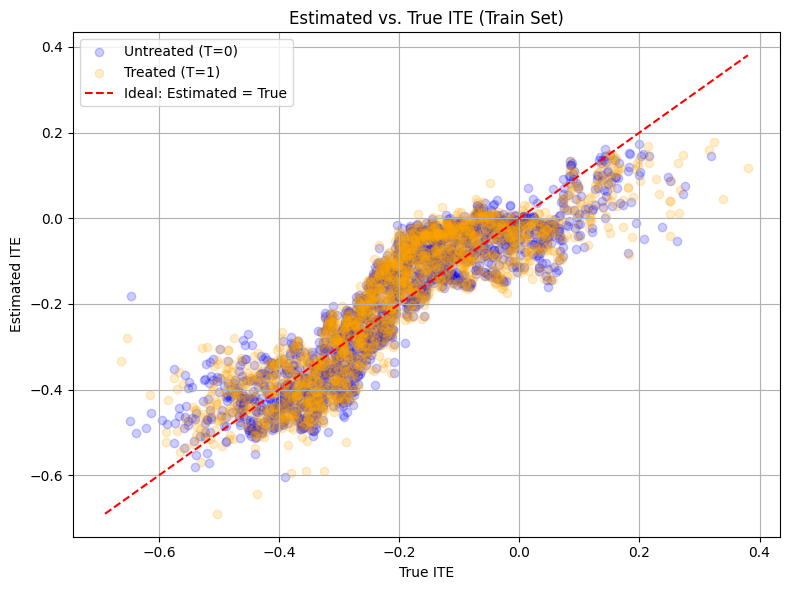

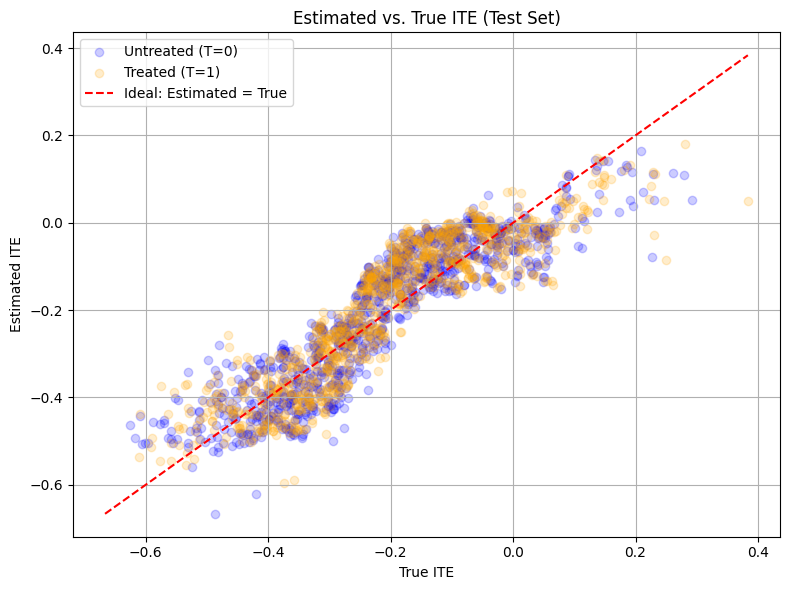

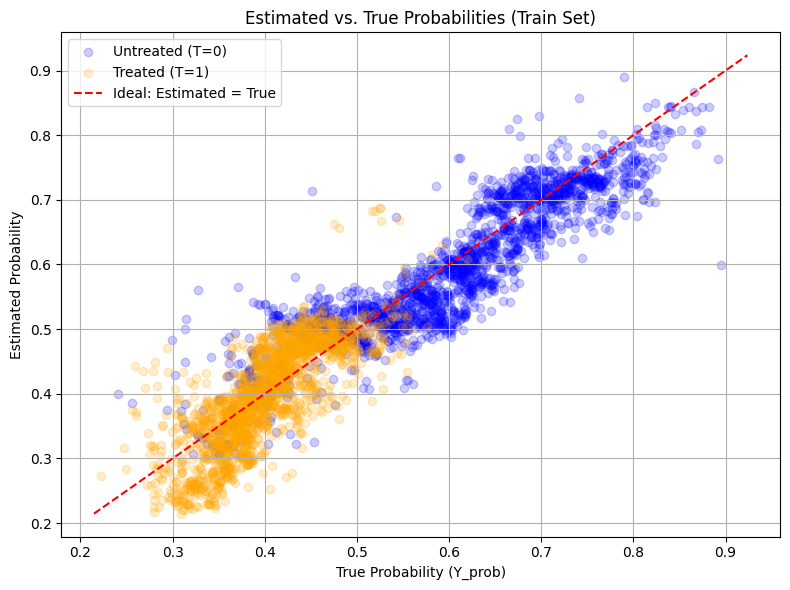

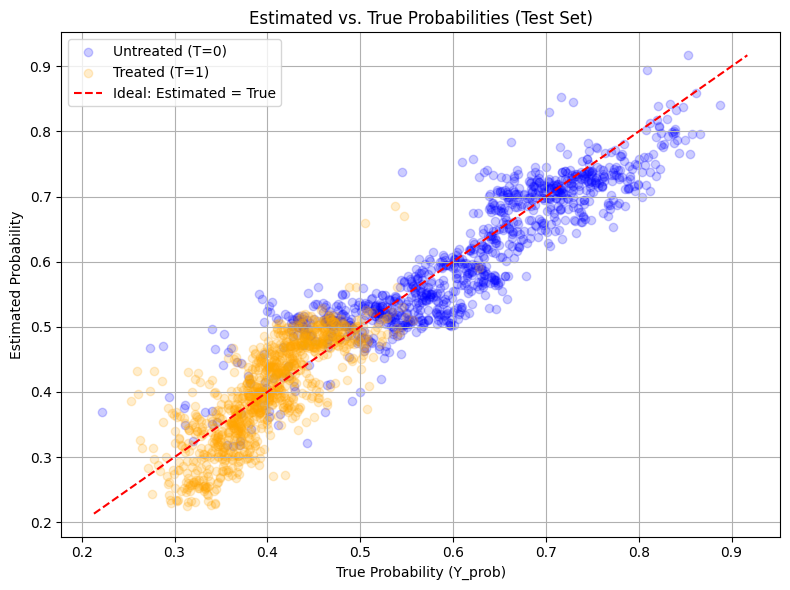

Estimated ATE (train): -0.1950
Estimated ATE (test):  -0.2023


In [8]:
feature_cols = ['X1', 'X2']
df_result_train, df_result_test, model_t, model_u = t_learner_random_forest_tuned(df_train, df_test, feature_cols)

if 'ITE_true' in df_result_test.columns:
    print("Test MAE:", np.mean(np.abs(df_result_test['ITE_hat'] - df_result_test['ITE_true'])))
if 'ITE_true' in df_result_train.columns:
    print("Train MAE:", np.mean(np.abs(df_result_train['ITE_hat'] - df_result_train['ITE_true'])))

plot_estimated_vs_true_ite_colored(df_result_train, title_suffix="(Train Set)")
plot_estimated_vs_true_ite_colored(df_result_test, title_suffix="(Test Set)")

plot_estimated_vs_true_probabilities(df_result_train, title_suffix='(Train Set)')
plot_estimated_vs_true_probabilities(df_result_test, title_suffix='(Test Set)')

estimated_ate_train = df_result_train['ITE_hat'].mean()
estimated_ate_test = df_result_test['ITE_hat'].mean()
print(f"Estimated ATE (train): {estimated_ate_train:.4f}")
print(f"Estimated ATE (test):  {estimated_ate_test:.4f}")

## NN

Early stopping at epoch 13


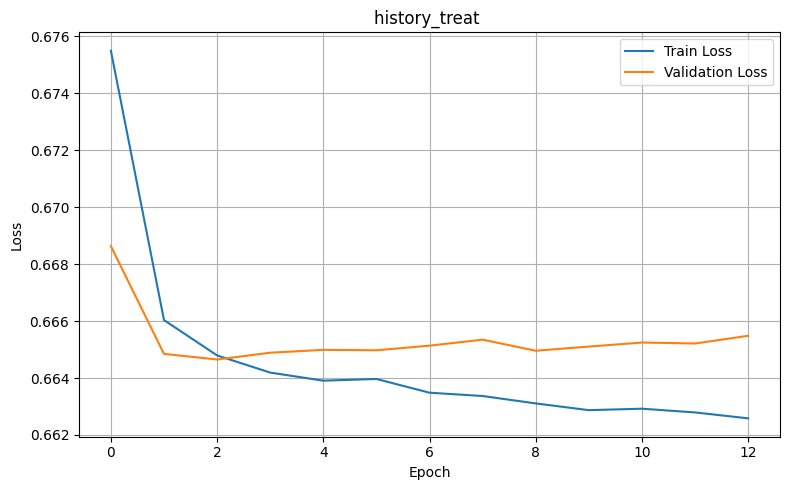

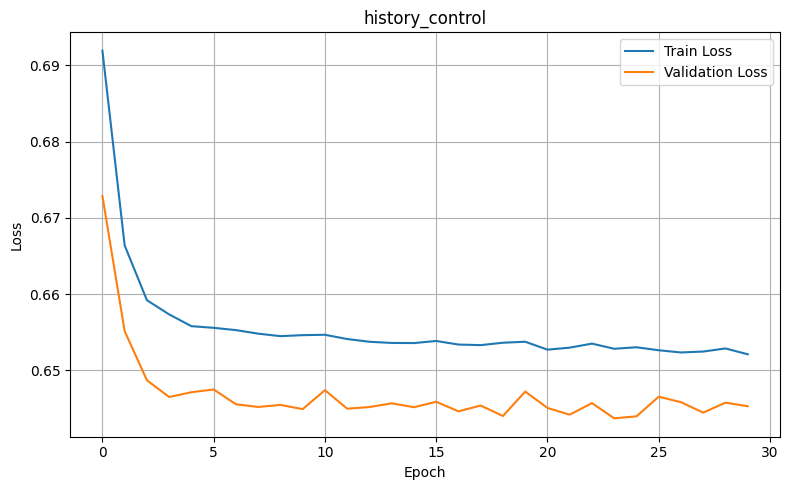

NN Test MAE: 0.04498826244730509
NN Train MAE: 0.045662202656998614


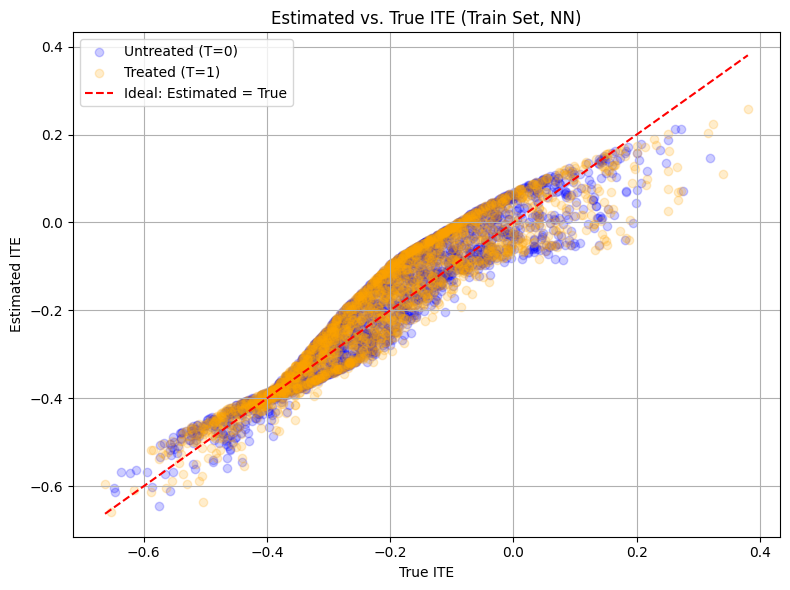

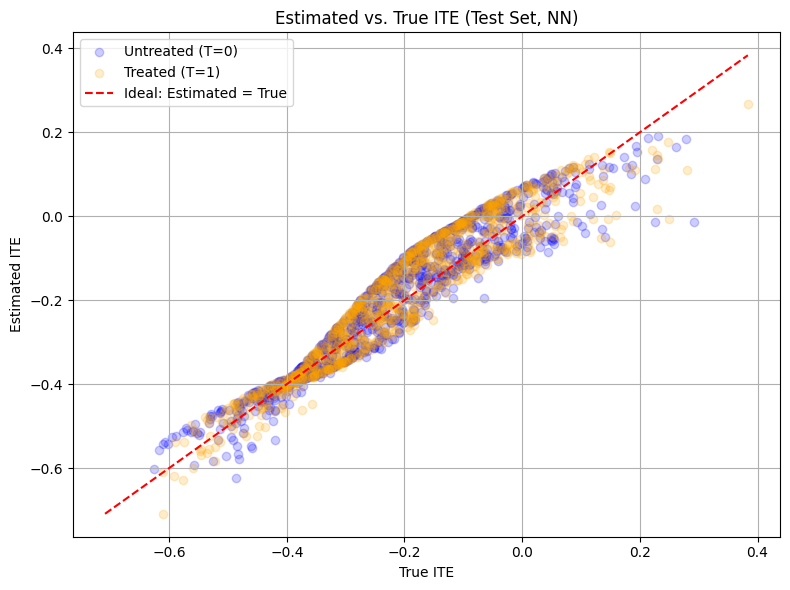

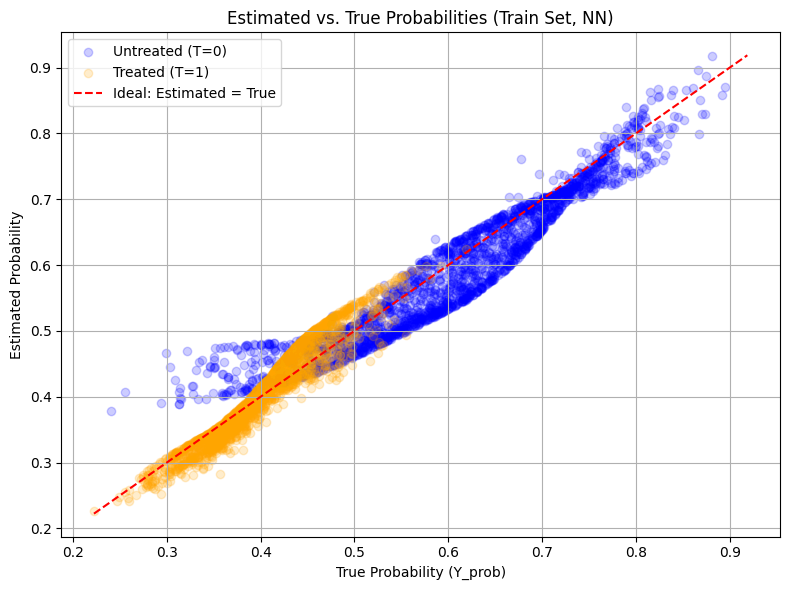

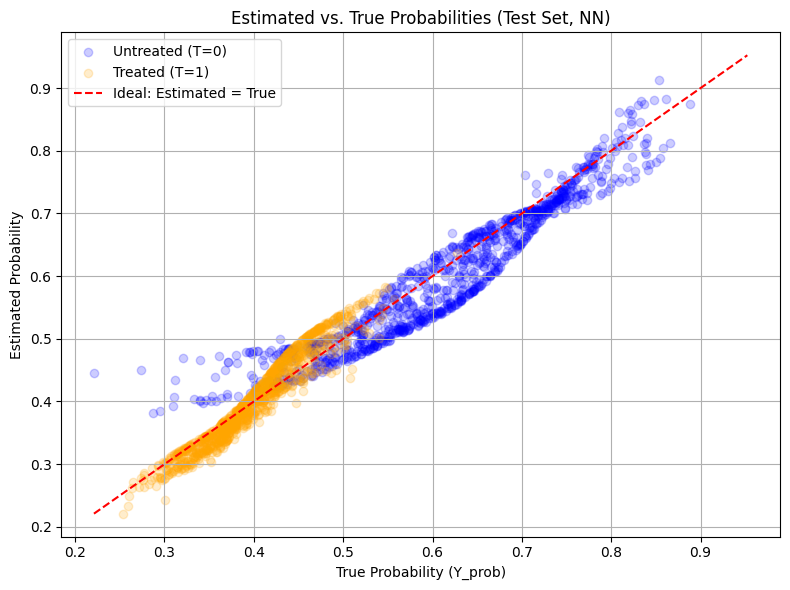

Estimated ATE (train): -0.1864
Estimated ATE (test):  -0.1955


In [9]:
# Run T-learner with Neural Networks
df_result_train, df_result_test, model_treat, model_control, history_treat, history_control = t_learner_nn(
    df_train, df_test,
    feature_cols=['X1', 'X2'],
    epochs=30,
    batch_size=128,
    lr=1e-3
)

plot_nn_training_history(history_treat, title='history_treat ')
plot_nn_training_history(history_control, title='history_control')

# Evaluate
print("NN Test MAE:", np.mean(np.abs(df_result_test['ITE_hat'] - df_result_test['ITE_true'])))
print("NN Train MAE:", np.mean(np.abs(df_result_train['ITE_hat'] - df_result_train['ITE_true'])))

plot_estimated_vs_true_ite_colored(df_result_train, title_suffix='(Train Set, NN)')
plot_estimated_vs_true_ite_colored(df_result_test, title_suffix='(Test Set, NN)')

plot_estimated_vs_true_probabilities(df_result_train, title_suffix='(Train Set, NN)')
plot_estimated_vs_true_probabilities(df_result_test, title_suffix='(Test Set, NN)')


estimated_ate_train = df_result_train['ITE_hat'].mean()
estimated_ate_test = df_result_test['ITE_hat'].mean()
print(f"Estimated ATE (train): {estimated_ate_train:.4f}")
print(f"Estimated ATE (test):  {estimated_ate_test:.4f}")


## RF hyperparemeter search

In [10]:
# df_result_train, df_result_test, model_t, model_u, grid_t, grid_u = t_learner_rf_with_tuning(
#     df_train=df_train,
#     df_test=df_test,
#     feature_cols=[col for col in df.columns if col.startswith("X")]
# )

# print("Best params (treated):", grid_t.best_params_)
# print("Best params (untreated):", grid_u.best_params_)

# Best params (treated): {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 700}
# Best params (untreated): {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}